In [340]:
from ib_insync import *
import numpy as np
import pandas as pd
import datetime as dt
pd.options.display.float_format = '{:,.4f}'.format
%matplotlib inline
from scipy.stats import norm as norm
util.startLoop()
import matplotlib.pyplot as plt
ib = IB()
ib.connect('127.0.0.1', 7496, clientId=12)

<IB connected to 127.0.0.1:7496 clientId=12>

In [392]:
spx = Index('SPX', 'CBOE')
vix = Index('VIX', 'CBOE')
ib.qualifyContracts(spx)

[ticker_spx] = ib.reqTickers(spx)
[ticker_vix] = ib.reqTickers(vix)
#ticker

curr_spx = ticker_spx.last
curr_vix = ticker_vix.last

chains = ib.reqSecDefOptParams(spx.symbol, '', spx.secType, spx.conId)

chains_df = util.df(chains)
chain = next(c for c in chains if c.tradingClass == 'SPXW' and c.exchange == 'SMART')

bounds = curr_spx*2*(curr_vix/(np.sqrt(52)*100))
expirations = 2

strikes = [strike for strike in chain.strikes
           if strike % 5 == 0
           and curr_spx - bounds < strike < curr_spx + bounds]
expirations = sorted(exp for exp in chain.expirations)[:expirations]
rights = ['P', 'C']

contracts = [Option('SPX', expiration, strike, right, 'SMART')
        for right in rights
        for expiration in expirations
        for strike in strikes]

ib.qualifyContracts(*contracts)
len(contracts)

spx_options = ib.reqTickers(*contracts)

def create_dfrow(curr_option):
    df_row = pd.DataFrame({'Symbol': curr_option.contract.localSymbol, 
                           'Type':curr_option.contract.right, 
                           'Bid': curr_option.bid, 
                           'Ask': curr_option.ask, 'Volume': curr_option.volume, 
                           'Strike': curr_option.contract.strike,
                           'Expiry': dt.datetime.strptime(curr_option.contract.lastTradeDateOrContractMonth, '%Y%m%d'),
                           'bidIV': curr_option.bidGreeks.impliedVol, 'bidDelta': curr_option.bidGreeks.delta,
                           'bidGamma': curr_option.bidGreeks.gamma, 'bidVega': curr_option.bidGreeks.vega,
                           'bidTheta': curr_option.bidGreeks.theta, 'askIV': curr_option.askGreeks.impliedVol, 
                           'askDelta': curr_option.askGreeks.delta,
                           'askGamma': curr_option.askGreeks.gamma, 'askVega': curr_option.askGreeks.vega,
                           'askTheta': curr_option.askGreeks.theta}, index = [0])
    return df_row

def plot_greeks(options_df):
    options_df = options_df[(abs(options_df.askDelta) <= 0.5) & (options_df.Bid > 0.05)]
    ax = options_df[options_df.Expiry == expiry].plot(figsize = (20,10), x='Strike', y='askDelta',
                                                       title = 'Delta')
    ax.set_xticks(options_df[options_df.Expiry == expiry].Strike);
    ax.set_xticklabels(options_df[options_df.Expiry == expiry].Strike, rotation=45);

    plt.show()

    options_df = options_df[(abs(options_df.askDelta) <= 0.5) & (options_df.Bid > 0.05)]
    ax = options_df[options_df.Expiry == expiry].plot(figsize = (20,10), x='Strike', y='askGamma',
                                                       title = 'Gamma')
    ax.set_xticks(options_df[options_df.Expiry == expiry].Strike);
    ax.set_xticklabels(options_df[options_df.Expiry == expiry].Strike, rotation=45);

    plt.show()

    options_df = options_df[(abs(options_df.askDelta) <= 0.5) & (options_df.Bid > 0.05)]
    ax = options_df[options_df.Expiry == expiry].plot(figsize = (20,10), x='Strike', y='askTheta',
                                                       title = 'Theta')
    ax.set_xticks(options_df[options_df.Expiry == expiry].Strike);
    ax.set_xticklabels(options_df[options_df.Expiry == expiry].Strike, rotation=45);

    plt.show()

    options_df = options_df[(abs(options_df.askDelta) <= 0.5) & (options_df.Bid > 0.05)]
    ax = options_df[options_df.Expiry == expiry].plot(figsize = (20,10), x='Strike', y='askIV',
                                                       title = 'IV')
    ax.set_xticks(options_df[options_df.Expiry == expiry].Strike);
    ax.set_xticklabels(options_df[options_df.Expiry == expiry].Strike, rotation=45);

def get_spreads(weekly_options):
    commissions = 0.0266

    spreads = []
    ev_lsts = []
    for idx, row in weekly_options.iterrows():

        curr_spread = weekly_options[['Expiry','Type']].head(1).reset_index(drop = True)
        typ = row.Type

        if typ == 'P':
            long_leg = weekly_options[weekly_options.Strike == row.Strike - 5].reset_index(drop = True)
        elif typ == 'C':
            long_leg = weekly_options[weekly_options.Strike == row.Strike + 5].reset_index(drop = True)

        if len(long_leg) == 0:
            break

        curr_spread['ShortStrike'] = row.Strike
        curr_spread['LongStrike'] = long_leg.loc[0,'Strike']

        curr_spread['ShortBid'] = row.Bid
        curr_spread['LongAsk'] = long_leg.loc[0,'Ask']

        curr_spread['ShortStrikeDelta'] = row.askDelta

        curr_spread['Credit'] = curr_spread['ShortBid'] - curr_spread['LongAsk'] - commissions
        curr_spread['Delta'] = long_leg.loc[0,'askDelta'] - row.askDelta
        curr_spread['Gamma'] = long_leg.loc[0,'askGamma'] - row.askGamma
        try:
            curr_spread['Theta'] = long_leg.loc[0,'askTheta'] - row.askTheta
        except:
            try:
                curr_spread['Theta'] = long_leg.loc[0,'askTheta'] - row.bidTheta
            except:
                curr_spread['Theta'] = long_leg.loc[0,'bidTheta'] - row.bidTheta
            
        
        curr_spread['Vega'] = long_leg.loc[0,'askVega'] - row.askVega

        stepsize = 0.01
        period_iv = np.sqrt(row.time_remaining)*curr_vix/100
        #curr_spread['EV'] = np.nan
        #curr_spread['Win Prob'] = np.nan

        if typ == 'P':
            curr_spread['MaxLoss'] = (curr_spread['LongStrike'] - curr_spread['ShortStrike'])*100 + curr_spread['Credit']*100
            curr_spread['BreakEven'] = curr_spread['ShortStrike'] - curr_spread.Credit

            ev_df = pd.DataFrame({'SPX': np.arange(long_leg.loc[0,'Strike'], row.Strike + stepsize, stepsize)})
            ev_df = ev_df[(ev_df['SPX'] < row.Strike + stepsize)]
            ev_df['PnL'] = ev_df['SPX'] - row.Strike + curr_spread.loc[0,'Credit']

        if typ == 'C':
            curr_spread['MaxLoss'] = (curr_spread['ShortStrike'] - curr_spread['LongStrike'])*100 + curr_spread['Credit']*100
            curr_spread['BreakEven'] = curr_spread['ShortStrike'] + curr_spread.Credit

            ev_df = pd.DataFrame({'SPX': np.arange(row.Strike, long_leg.loc[0,'Strike'] + stepsize, stepsize)})
            ev_df = ev_df[(ev_df['SPX'] < long_leg.loc[0,'Strike'] + stepsize)]
            ev_df['PnL'] = row.Strike - ev_df['SPX'] + curr_spread.loc[0,'Credit']

        ev_df['Prob'] = norm.cdf(ev_df['SPX']/curr_spx - 1,0, period_iv)
        lb = ev_df.loc[0,'Prob']
        ub = ev_df.loc[len(ev_df) - 1,'Prob']
        ev_df['Prob'] = ev_df['Prob'].diff()
        ev_df.loc[0,'Prob'] = lb
        ev_df.loc[len(ev_df) - 1, 'Prob'] = 1 - ub
        ev_df['EV'] = ev_df.Prob*ev_df.PnL

        ev_lsts.append(ev_df)
        total_ev = sum(ev_df['EV'])
        win_prob = sum(ev_df[ev_df['PnL'] >= 0]['Prob'])

        curr_spread['EV'] = total_ev
        curr_spread['Win Prob'] = win_prob

        spreads.append(curr_spread)

    spreads = pd.concat(spreads, axis = 0).sort_values('EV', ascending = False).reset_index(drop = True)
    return spreads, ev_lsts

puts_rows = []
calls_rows = []

for curr_option in spx_options:
    curr_row = create_dfrow(curr_option)
    if curr_option.contract.right == 'P':
        puts_rows.append(curr_row)
    elif curr_option.contract.right == 'C':
        calls_rows.append(curr_row)
        
puts = pd.concat(puts_rows).reset_index(drop = True).sort_values(['Expiry','Strike'])
calls = pd.concat(calls_rows).reset_index(drop = True).sort_values(['Expiry','Strike'])

t_calc_df = calls[abs(calls.Strike - curr_spx) <= 25][['Expiry','Volume','askIV','bidIV','askDelta','bidDelta','Strike']]


a = (t_calc_df['askIV']**2)/2
b = -t_calc_df['askIV']*norm.ppf(t_calc_df['askDelta'])
c = np.log(curr_spx/t_calc_df['Strike'])

t_calc_df['time_remaining_add'] = ((-b - np.sqrt(b**2 - 4*a*c))/(2*a))**2
t_calc_df['time_remaining_sub'] = ((-b + np.sqrt(b**2 - 4*a*c))/(2*a))**2

t_calc_df['time_remaining'] = (t_calc_df['time_remaining_add'] < 1)*t_calc_df['time_remaining_add'] + (t_calc_df['time_remaining_sub'] < 1)*t_calc_df['time_remaining_sub']

t_calc_df['time_remaining_prelim'] = (t_calc_df['time_remaining_add'] < 1)*t_calc_df['time_remaining_add'] + (t_calc_df['time_remaining_sub'] < 1)*t_calc_df['time_remaining_sub']

t_calc_df = t_calc_df.dropna()
t_calc_df = pd.merge(t_calc_df, t_calc_df[['Expiry','Volume']].groupby('Expiry').sum().reset_index(), on = 'Expiry')
t_calc_df['VolumeWeight'] = t_calc_df['Volume_x']/t_calc_df['Volume_y']

t_calc_df['time_remaining'] = t_calc_df['time_remaining_prelim']*t_calc_df['VolumeWeight']

t_calc_df = t_calc_df[['Expiry','time_remaining']].dropna().groupby('Expiry').mean().reset_index()

puts = pd.merge(puts,t_calc_df, on = 'Expiry')
calls = pd.merge(calls,t_calc_df, on = 'Expiry')

print('Curr SPX:{}'.format(curr_spx))
print('Curr VIX:{}'.format(curr_vix))

Started to throttle requests
Stopped to throttle requests
Started to throttle requests
Stopped to throttle requests


Curr SPX:2744.73
Curr VIX:15.47


In [393]:
expiry = t_calc_df.loc[0, 'Expiry']

bid_threshold = 0.25

net_delta_threshold = 0.5

weekly_puts = puts[puts['Expiry'] == expiry]
weekly_puts = weekly_puts[(weekly_puts.Strike <= curr_spx) & 
                          (weekly_puts['Bid'] >= bid_threshold)].sort_values('Strike', ascending = False)
weekly_puts = weekly_puts.drop_duplicates(subset = ['Strike'], keep = 'last').reset_index(drop = True)

weekly_calls = calls[calls['Expiry'] == expiry]
weekly_calls = weekly_calls[(weekly_calls.Strike >= curr_spx) & 
                            (weekly_calls['Bid'] >= bid_threshold)].sort_values('Strike', ascending = True)
weekly_calls = weekly_calls.drop_duplicates(subset = ['Strike'], keep = 'last').reset_index(drop = True)

call_spreads, ev_lsts_calls = get_spreads(weekly_calls)
put_spreads, ev_lsts_puts = get_spreads(weekly_puts)

filtered_spreads = pd.concat([call_spreads[(call_spreads.Credit >= 0.5)],
                              put_spreads[(put_spreads.Credit >= 0.5)]], axis = 0)

filtered_spreads

Expiry Type  ShortStrike  LongStrike  ShortBid  LongAsk  \
0 2019-02-13    C   2,755.0000  2,760.0000    2.6500   1.7000   
1 2019-02-13    C   2,760.0000  2,765.0000    1.6000   0.9500   
2 2019-02-13    C   2,750.0000  2,755.0000    4.2000   2.8500   
5 2019-02-13    C   2,745.0000  2,750.0000    6.4000   4.5000   
0 2019-02-13    P   2,730.0000  2,725.0000    2.6000   2.0000   
1 2019-02-13    P   2,735.0000  2,730.0000    3.6000   2.8000   
2 2019-02-13    P   2,740.0000  2,735.0000    5.1000   3.9000   

   ShortStrikeDelta  Credit   Delta   Gamma  Theta    Vega   MaxLoss  \
0            0.2049  0.9234 -0.0810 -0.0053 0.6154 -0.1138 -407.6600   
1            0.1239  0.6234 -0.0568 -0.0049 0.6161 -0.1069 -437.6600   
2            0.3121  1.3234 -0.1072 -0.0045 0.5617 -0.0999 -367.6600   
5            0.4383  1.8734 -0.1263 -0.0019 0.4155 -0.0578 -312.6600   
0           -0.2236  0.5734  0.0698 -0.0042 0.5190 -0.0886 -442.6600   
1           -0.3168  0.7734  0.0933 -0.0042 0.3604 -0.0821 -422.6600   
2           -0.4318  1.1734  0.1150 -0.0031 0.1788 -0.0530 -382.6600   

   BreakEven     EV  Win Prob  
0 2,755.9234 0.6942    0.9339  
1 2,760.6234 0.5761    0.9837  
2 2,751.3234 0.5613    0.8124  
5 2,746.8734 0.0872    0.6133  
0 2,729.4266 0.5164    0.9802  
1 2,734.2266 0.5080    0.9211  
2 2,738.8266 0.3245    0.7863

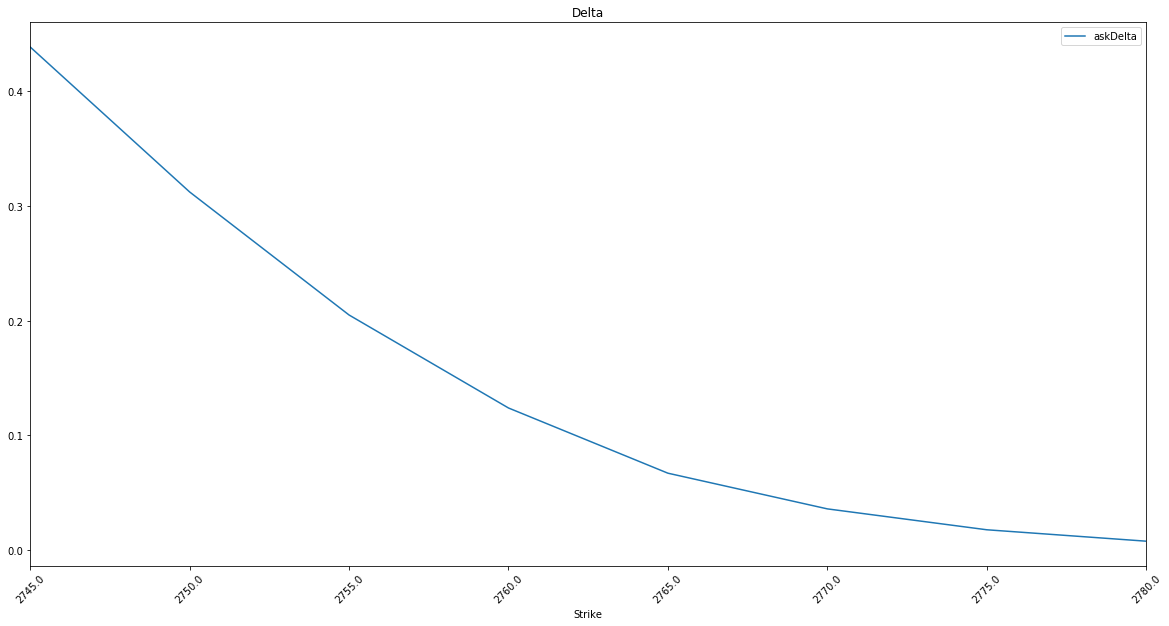

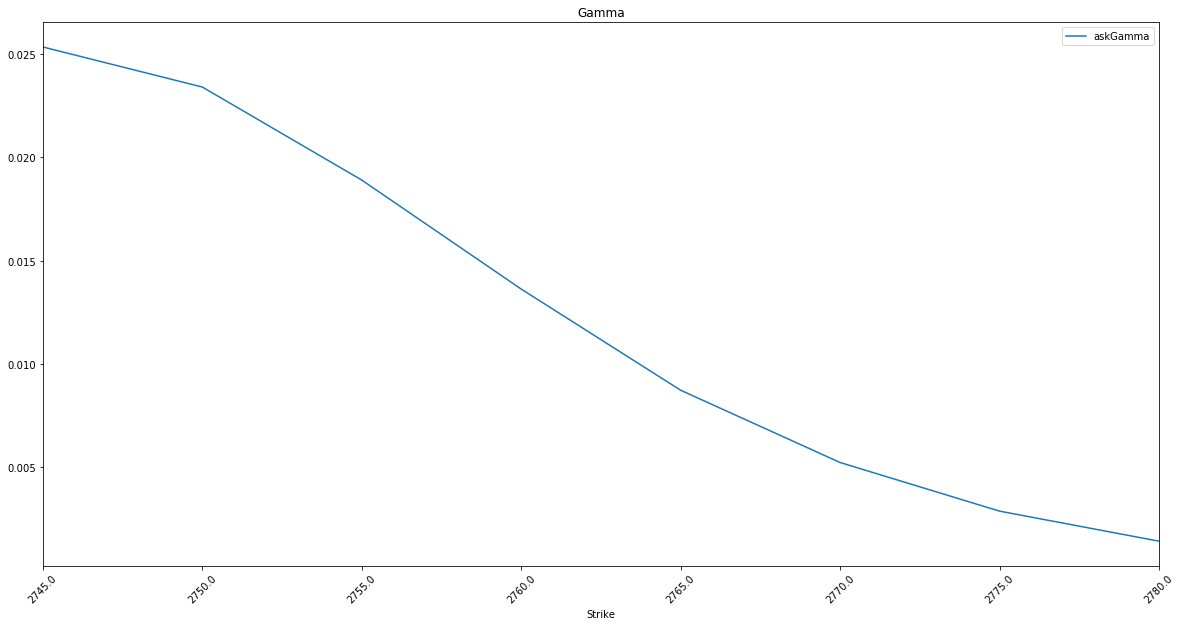

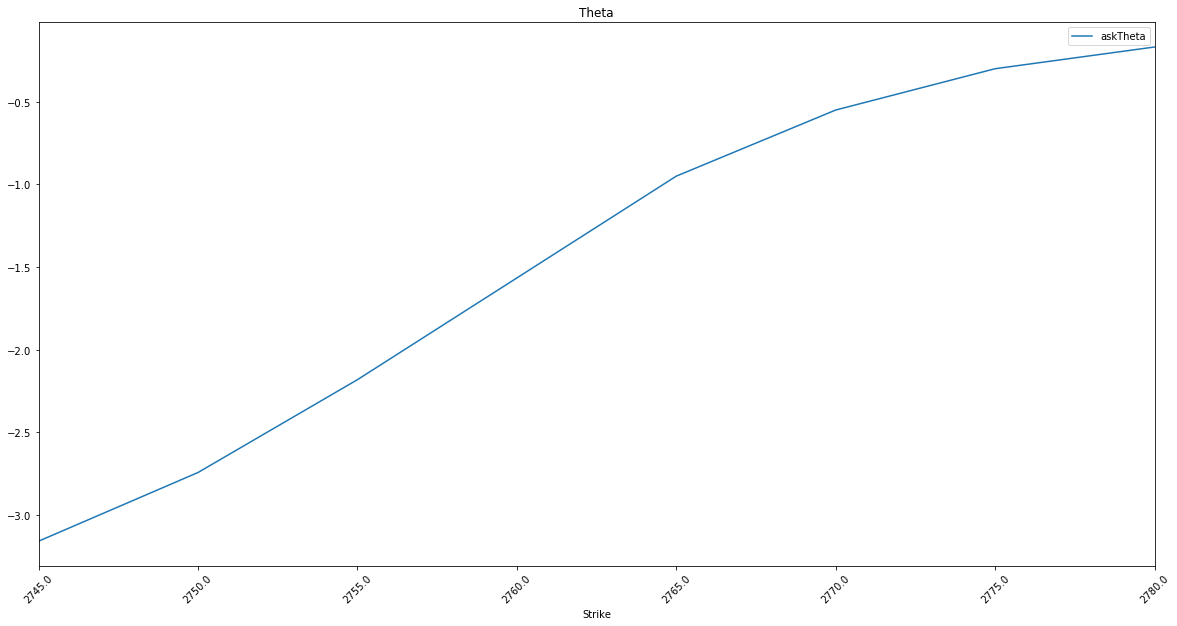

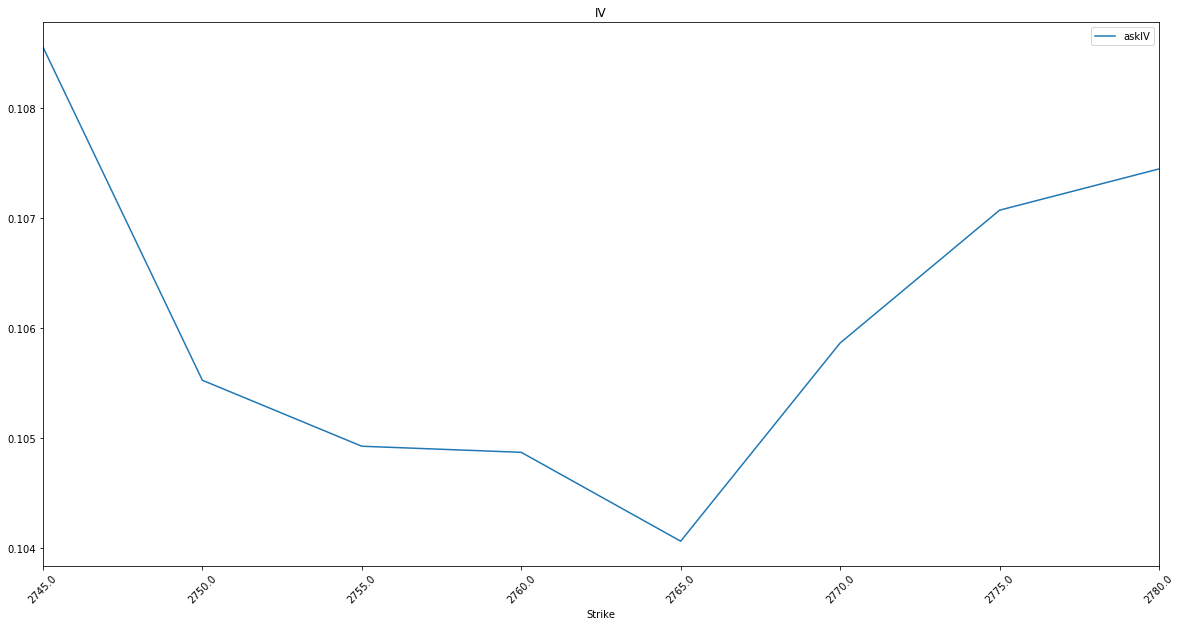

In [394]:
plot_greeks(calls)

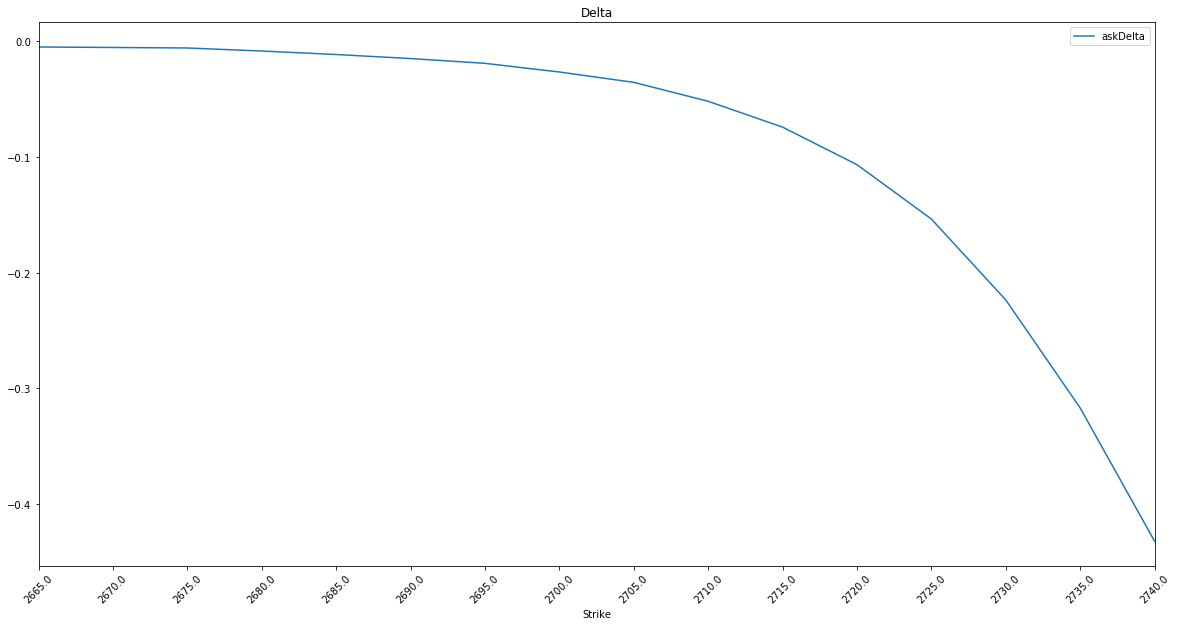

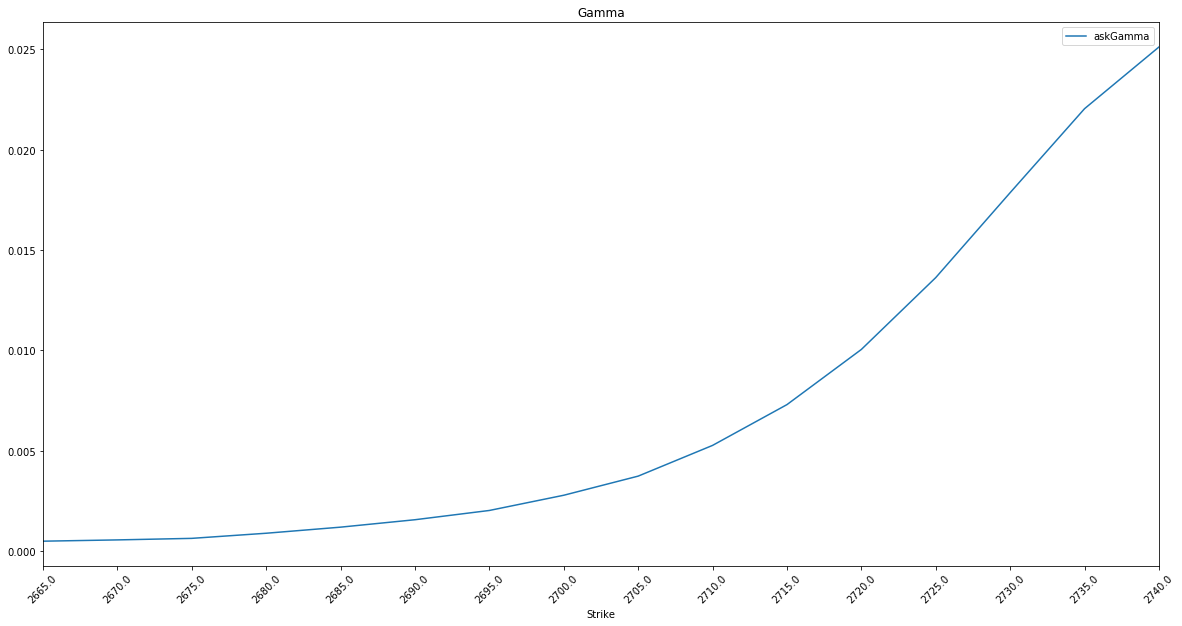

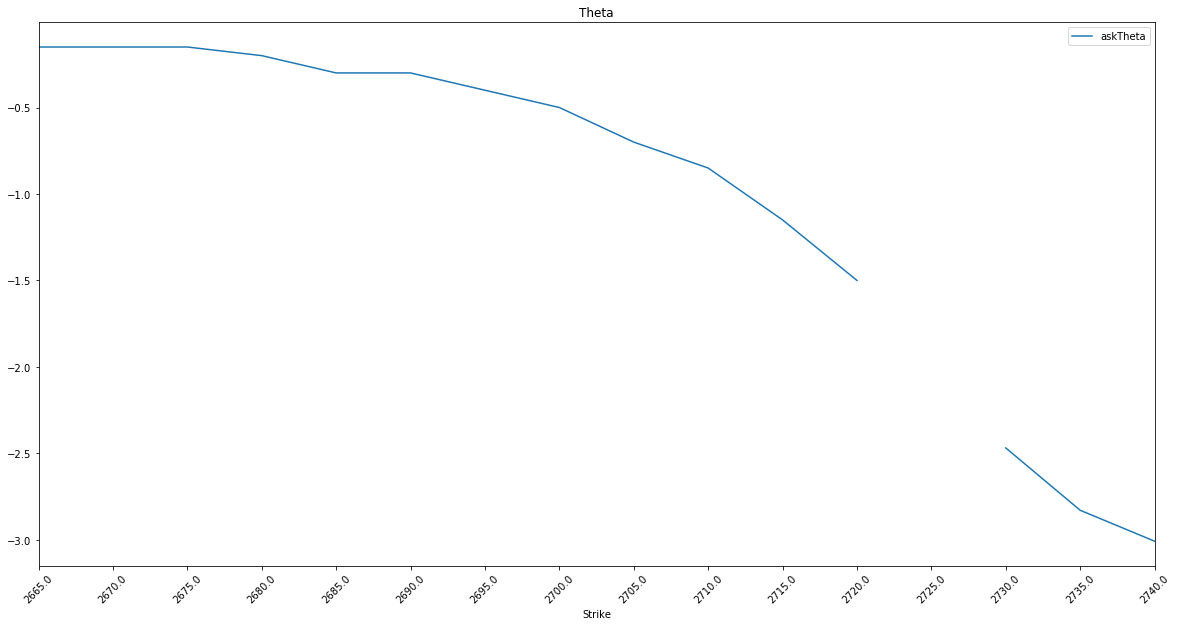

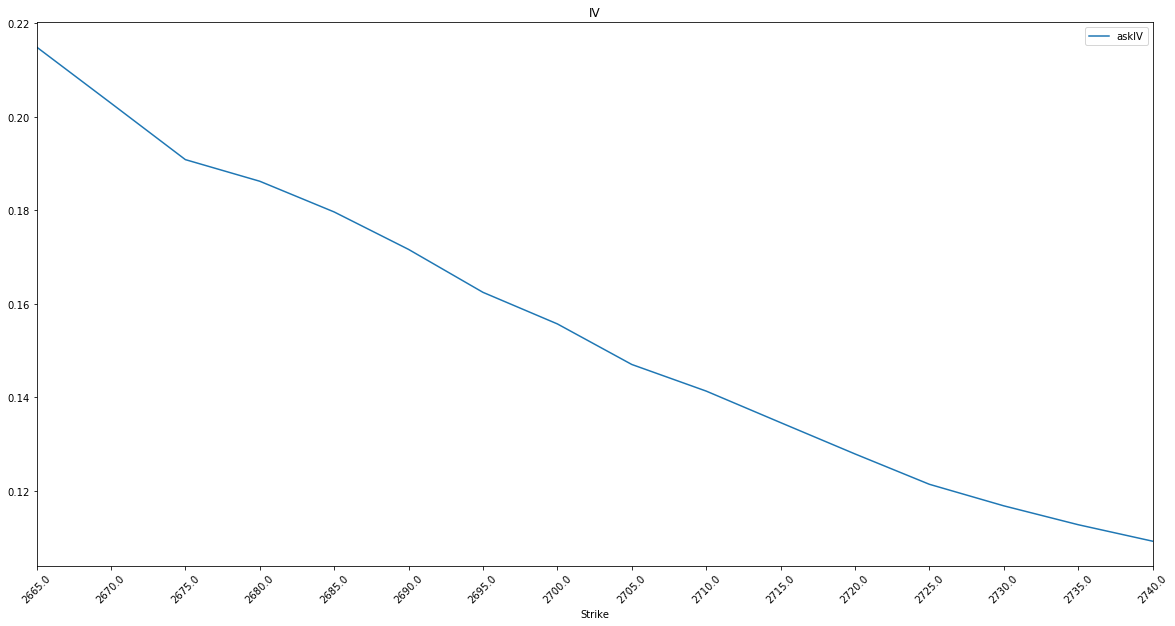

commissionReport: No execution found for CommissionReport(execId='0001417f.5c62d9fd.02.01', commission=7.4292, currency='USD')
commissionReport: No execution found for CommissionReport(execId='0001417f.5c62d9fd.03.01', commission=7.9692, currency='USD')


In [395]:
plot_greeks(puts)

In [397]:

ib.disconnect()